<a href="https://colab.research.google.com/github/SunshyPiKaChew/seq2seq_attention/blob/master/seq_seq_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!pip install tensorflow==2.0.0-beta1
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

from tensorflow import keras

In [4]:
! /opt/bin/nvidia-smi

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [5]:
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
  print(module.__name__, module.__version__)

2.4.1
sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.5
pandas 1.1.5
sklearn 0.22.2.post1
tensorflow 2.4.1
tensorflow.keras 2.4.0


In [6]:
# 1. preprocessing data
# 2. build model
# 2.1 encoder
# 2.2 attetion
# 2.3 decoder
# 3. evaluation
# 3.1 given sentence. return translate results
# 3.2 visualize results (attention)

In [7]:
# unicode2ascii 去掉西班牙语的重音
import unicodedata
def unicode_to_ascii(s):
  # normalize 的 NFD 方法，如果一个unicode值包含多个字符，那么把他拆开，例如e和重音分开
  # 'Mn' 重音的分类标志
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
en_sentence = 'Then what?'
sp_sentence = '¿Entonces qué?'

print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))

Then what?
¿Entonces que?


In [8]:
# 字符串预处理
import re
def preprocess_sentence(s):
  s = unicode_to_ascii(s.lower().strip())
  # [] 匹配操作 () 替换操作 前后加空格
  s = re.sub(r"([?.!,¿])", r" \1 ", s)
  # 将一个或多个空格替换为一个空格
  s = re.sub(r'[" "]+', " ", s)
  # 除了字母和标点符号都替换为空格
  s = re.sub(r'[^a-zA-Z?.!,¿]', " ", s)
  # 去掉前后的空格
  s = s.rstrip().strip()
  # 添加前后特殊字符
  s = '<start> ' + s + ' <end>'
  return s

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))


<start> then what ? <end>
<start> ¿ entonces que ? <end>


In [9]:
from google.colab import drive
drive.mount('/content/drive')
en_spa_file_path = '/content/drive/MyDrive/Colab/chapter_10/data_spa_en/spa.txt'

# 非挂载方式
#en_spa_file_path = '/content/train_local/spa.txt'

# 尝试2
#!mkdir ./data
#!cp ./drive/MyDrive/Colab\ Notebooks/spa.zip ./data/
#!cd ./data && unzip spa.zip
#en_spa_file_path = './data/spa.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
def parse_data(filename):
  # 根据回车分割数据中的每一行
  lines = open(filename, encoding='UTF-8').read().strip().split('\n')
  # 根据制表符分割西班牙文和英文
  sentence_pairs = [line.split('\t') for line in lines]
  preprocessed_sentence_pairs = [
    (preprocess_sentence(en), preprocess_sentence(sp)) for en,sp in sentence_pairs]
  return zip(*preprocessed_sentence_pairs)

en_dataset, sp_dataset = parse_data(en_spa_file_path)
print(en_dataset[-1])
print(sp_dataset[-1])


<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [11]:
# 文本式数据转化为ID式数据
def tokenizer(lang):
  lang_tokenizer = keras.preprocessing.text.Tokenizer(num_words = None, filters='', split=' ')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  # Padding
  tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
  return tensor, lang_tokenizer

input_tensor, input_tokenizer = tokenizer(sp_dataset[0:30000])
output_tensor, output_tokenizer = tokenizer(en_dataset[0:30000])

def max_length(tensor):
  return max(len(t) for t in tensor)

max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)
print(max_length_input, max_length_output)

16 11


In [12]:
# 调用sklearn函数分割数据集
from sklearn.model_selection import train_test_split
input_train, input_eval, output_train, output_eval = train_test_split(input_tensor, output_tensor, test_size = 0.2)
len(input_train),len(input_eval), len(output_train), len(output_eval)

(24000, 6000, 24000, 6000)

In [13]:
def convert(example, tokenizer):
  for t in example:
    if t != 0:
      print('%d --> %s' % (t,tokenizer.index_word[t]))

convert(input_train[0],input_tokenizer)
print()
convert(output_train[0],output_tokenizer)

1 --> <start>
1095 --> admiro
10 --> a
4 --> tom
3 --> .
2 --> <end>

1 --> <start>
4 --> i
1024 --> admire
5 --> tom
3 --> .
2 --> <end>


In [14]:
# 比如训练集有50000个样本，而我设定的batch_size是50，也就是说每50个样本才更新一次参数，那么也就意味着一个epoch里会提取1000次bach，
# 这样才会把每个样本都提取了一遍，更新了1000次参数。

# 这是一个epoch里做的，依次类推，我要设定2000个epoch意味着把这个过程重复2000次。也就是训练集里的每个样本都被提取了2000次。

# 生成DataSet
def make_dataset(input_tensor, output_tensor, batch_size, epochs, shuffle):
  dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor))
  if shuffle:
    dataset = dataset.shuffle(30000)
  dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder = True)
  return dataset

batch_size = 64;
epochs = 20

train_dataset = make_dataset(input_train, output_train, batch_size, epochs, True)
eval_dataset = make_dataset(input_eval, output_eval, batch_size, epochs, False)

# 64 是一个bacth的大小 16 11 分别为输入输出padding之后的大小
for x,y in train_dataset.take(1):
  print(x.shape)
  print(y.shape)
  print(x)
  print(y)

(64, 16)
(64, 11)
tf.Tensor(
[[   1   30   55 ...    0    0    0]
 [   1    6  137 ...    0    0    0]
 [   1    6 1656 ...    0    0    0]
 ...
 [   1   13  366 ...    0    0    0]
 [   1   52   36 ...    0    0    0]
 [   1  352  849 ...    0    0    0]], shape=(64, 16), dtype=int32)
tf.Tensor(
[[   1   19   26    9  506    3    2    0    0    0    0]
 [   1  486  192    7    2    0    0    0    0    0    0]
 [   1   22    6  207 1916    7    2    0    0    0    0]
 [   1    4   35  327    3    2    0    0    0    0    0]
 [   1    4   63  162 3080    3    2    0    0    0    0]
 [   1   25 1593  246    7    2    0    0    0    0    0]
 [   1   16   65  160  338    3    2    0    0    0    0]
 [   1   20   11   21  310    3    2    0    0    0    0]
 [   1   10  678   17  691    3    2    0    0    0    0]
 [   1   14  511  295  109    3    2    0    0    0    0]
 [   1    4  161 1273 1216    3    2    0    0    0    0]
 [   1  174   13 2070    3    2    0    0    0    0    0]
 [   1

In [15]:
# 超参数定义

# 将单词进行编码，编码长度为256
embedding_units = 256   
# 中间循环神经网络 encoder decoder  
units = 1024          
# 输入词表长度
input_vocab_size = len(input_tokenizer.word_index) + 1
# 输出词表长度
output_vocab_size = len(output_tokenizer.word_index) + 1

In [16]:
# 调用子类API
class Encoder(tf.keras.Model):
  # 初始化函数
  def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
    # 调用父类初始化函数
    super(Encoder, self).__init__()
    # 赋初值
    self.batch_size = batch_size;
    self.encoding_units = encoding_units;
    # 一个规定输入词表大小和输出编码大小的编码器
    self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
    # 每一步的隐层状态： 矩阵 hide_state 最后一步的输出：cell_state
    self.gru = keras.layers.GRU(self.encoding_units, return_sequences = True, return_state = True, recurrent_initializer = 'glorot_uniform')
  def call(self, x, hidden):
    # 输入编码
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    # 每一步输出和最后一次输出的隐含状态
    return output, state

  def initialize_hidden_state(self):    
    return tf.zeros((self.batch_size, self.encoding_units))

encoder = Encoder(input_vocab_size, embedding_units, units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder.call(x, sample_hidden)
print('output_shape')
print(sample_output.shape)
print('decoder_hidden_shape')
print(sample_hidden.shape)


output_shape
(64, 16, 1024)
decoder_hidden_shape
(64, 1024)


In [17]:
class BahdanauAttention(keras.Model):
  def __init__(self, units):
    # units 全连接层的维度 y = A * x
    super(BahdanauAttention, self).__init__()
    self.W1 = keras.layers.Dense(units)
    self.W2 = keras.layers.Dense(units)
    self.V = keras.layers.Dense(1)
  def call(self, decoder_hidden, encoder_outputs):
    # decoder_hidden.shape: (batch_size,units) (64,1024)
    # encoder_outputs.shape: (batch_size, length, units) (64,16,1024)
    # decoder_hidden_with_time_axis: (batch_size,1,units) (64,1,1024)
    # 保证大的维度一致，就可以相加

    decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)

    # before V: (batch_size, length, units) 64 16 10
    # after V socre: (batch_size, length, 1)  64 16 1
    # self.W1(encoder_outputs) 64 16 10
    # self.W2(decoder_hidden_with_time_axis) 64 1 10
    # tanh不改变维度
    score = self.V(
        tf.nn.tanh(
            self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)
        )
    )

    # attention_weights.shape: (batch_size, length, 1)
    # attention 只和 单词（length） 有关系, 所以只能在length上做softmax
    attention_weights = tf.nn.softmax(score, axis = 1)
    
    # context_vector.shape: (batch_size, length, units) 64 16 1024
    # 维度不匹配的相乘(忽略batch_size 维度)
    # [attention_weight 按列复制1024份] * [encoder_outputs] 16*1024
    # attention_weight.shape() 64 16 1; encoder_outputs.shape() 64 16 1024
    # attention_weights 实际是length的权重
    context_vector = attention_weights * encoder_outputs
    
    # context_vector.shape: (batch_size, units) 64 1024
    context_vector = tf.reduce_sum(context_vector, axis = 1)

    return context_vector, attention_weights

attention_model = BahdanauAttention(units = 10)
attention_results, attention_weights = attention_model(sample_hidden, sample_output)

print("attention_results.shape:", attention_results.shape)
print("attention_weights.shape:", attention_weights.shape)

attention_results.shape: (64, 1024)
attention_weights.shape: (64, 16, 1)


In [18]:
class Decoder(keras.Model):
  def __init__(self, vocab_size, embedding_units, decoding_units, batch_size):
    super(Decoder, self).__init__()
    self.batch_size = batch_size
    self.decoding_units = decoding_units
    self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
    self.gru = keras.layers.GRU(self.decoding_units, return_sequences= True, return_state = True, recurrent_initializer = 'glorot_uniform')
    self.fc = keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(decoding_units)
  
  def call(self, x, hidden, encoding_outputs):
    # context_vector.shape: (batch_size, units) 64 1024
    context_vector, attention_weights = self.attention(hidden, encoding_outputs)
    # before embedding: x.shape: (batch_size,1) 64 1 一步编码，x长度是1不是16
    x = self.embedding(x)
    # after embedding: x.shape: (batch_size, 1, embedding_units) 64, 1, 256
    # 按照最后一个维度拼接
    combined_x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
    # output.shape: (batch_size, 1, decoding_units) 64 1 1024
    # state.shape: (batch_size, decoding_units) 64 1024
    output, state = self.gru(combined_x)

    # output.shape: (batch_size, decoding_units)
    output = tf.reshape(output, (-1, output.shape[2]))
    # output.shape： (batch_size, output_vocab_size)
    output = self.fc(output)

    return output, state, attention_weights

decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)
outputs = decoder(tf.random.uniform((batch_size, 1)), sample_hidden, sample_output)
decoder_output, decoder_hidden, decoder_aw = outputs
print("decoder_output.shape: ", decoder_output.shape)
print("decoder_hidden.shape: ", decoder_hidden.shape)
# attention 用的是sample数据，所以和16有关系
print("decoder_attention_weights.shape: ", decoder_aw.shape)

decoder_output.shape:  (64, 4935)
decoder_hidden.shape:  (64, 1024)
decoder_attention_weights.shape:  (64, 16, 1)


In [19]:
optimizer = keras.optimizers.Adam()
# from_logits: True->没经过softmax False->经过softmax
# reduction : mask 之后聚合
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

def loss_function(real, pred):
  # padding部分为0，非padding部分为1
  mask = tf.math.logical_not(tf.math.equal(real,0))
  loss_ = loss_object(real, pred)

  # 精度转化
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [20]:
@tf.function
def train_step(inp, targ, encoding_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    encoding_output, encoding_hidden = encoder(inp, encoding_hidden)
    decoding_hidden = encoding_hidden
    # eg:<start> I am here <end>
    # 1. <start> -> I
    # 2. I -> am
    # 3. am -> here
    # 4. here -> <end>
    for t in range(0, targ.shape[1] - 1):
      # batch_size 1
      decoding_input = tf.expand_dims(targ[:,t], 1)
      prediction, decoding_hidden, _ = decoder(decoding_input, decoding_hidden, encoding_output)
      loss += loss_function(targ[:,t+1], prediction)
    
  batch_loss = loss/int(targ.shape[0])
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

In [21]:
epochs = 10
step_per_epoch = len(input_tensor) // batch_size

for epoch in range(epochs):
  start = time.time()
  encoding_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  # enumerate的返回形式 (batch, (inp, targ))
  for(batch, (inp, targ)) in enumerate(train_dataset.take(step_per_epoch)):
    batch_loss = train_step(inp, targ, encoding_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch+1, batch, batch_loss.numpy()))
  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / step_per_epoch))
  print('Time take for 1 epoch {} sec\n'.format(time.time()-start))

Epoch 1 Batch 0 Loss 0.7931
Epoch 1 Batch 100 Loss 0.3765
Epoch 1 Batch 200 Loss 0.3205
Epoch 1 Batch 300 Loss 0.2840
Epoch 1 Batch 400 Loss 0.2504
Epoch 1 Loss 0.3333
Time take for 1 epoch 1747.8085074424744 sec

Epoch 2 Batch 0 Loss 0.2366
Epoch 2 Batch 100 Loss 0.2182
Epoch 2 Batch 200 Loss 0.2294
Epoch 2 Batch 300 Loss 0.2037
Epoch 2 Batch 400 Loss 0.1675
Epoch 2 Loss 0.2087
Time take for 1 epoch 1783.8532795906067 sec

Epoch 3 Batch 0 Loss 0.1424
Epoch 3 Batch 100 Loss 0.1524
Epoch 3 Batch 200 Loss 0.1617
Epoch 3 Batch 300 Loss 0.1556
Epoch 3 Batch 400 Loss 0.0953
Epoch 3 Loss 0.1297
Time take for 1 epoch 1806.8164820671082 sec

Epoch 4 Batch 0 Loss 0.0954
Epoch 4 Batch 100 Loss 0.0852
Epoch 4 Batch 200 Loss 0.0774
Epoch 4 Batch 300 Loss 0.0879
Epoch 4 Batch 400 Loss 0.0536
Epoch 4 Loss 0.0796
Time take for 1 epoch 1713.6320838928223 sec

Epoch 5 Batch 0 Loss 0.0408
Epoch 5 Batch 100 Loss 0.0464
Epoch 5 Batch 200 Loss 0.0495
Epoch 5 Batch 300 Loss 0.0601
Epoch 5 Batch 400 Loss 0.0

In [22]:
def evalute(input_sentence):
  attention_matrix = np.zeros((max_length_output, max_length_input))
  input_sentence = preprocess_sentence(input_sentence)

  inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
  inputs = keras.preprocessing.sequence.pad_sequences([inputs], maxlen = max_length_input, padding = 'post')
  inputs = tf.convert_to_tensor(inputs)
  results = ''
  encoding_hidden = tf.zeros((1,units))

  encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
  decoding_hidden = encoding_hidden

  # eg: <start> -> A -> B -> ...
  # decoding_input.shape (1,1) 为batch扩展维度
  decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']],0)
  
  for t in range(max_length_output):
    predictions, decoding_hidden, attention_weights = decoder(
        decoding_input, decoding_hidden, encoding_outputs)
    # attention_weights.shape: (batch_size, input_length, 1) (1,16,1)
    attention_weights = tf.reshape(attention_weights, (-1,))
    # attention_weights.shape: 1 16
    attention_matrix[t] = attention_weights.numpy()

    # predictions.shape: [batch_size, vocab_size] (1,4935)
    predicted_id = tf.argmax(predictions[0]).numpy()
    results += output_tokenizer.index_word[predicted_id] + ' '

    if output_tokenizer.index_word[predicted_id] == '<end>':
      return results, input_sentence, attention_matrix
    # decoding_input.shape (1,1) 为batch扩展维度
    decoding_input = tf.expand_dims([predicted_id],0)
  return results, input_sentence, attention_matrix

# 绘制attention_matrix
def plot_attention(attention_matrix, input_sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1,1,1)
  ax.matshow(attention_matrix, cmap = 'viridis')
  font_dict = {'fontsize': 14}
  ax.set_xticklabels([''] + input_sentence,
              fontdict = font_dict, rotation = 90)
  ax.set_yticklabels([''] + predicted_sentence,
              fontdict = font_dict,)
  plt.show()
  
def translate(input_sentence):
  results, input_sentence, attention_matrix = evalute(input_sentence)
  print("Input: %s" % (input_sentence))
  print("Predicted translation: %s" % (results))
  # 去除padding部分
  attention_matrix = attention_matrix[:len(results.split(' ')),
                      :len(input_sentence.split(' '))]
  plot_attention(attention_matrix, input_sentence.split(' '), results.split(' '))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


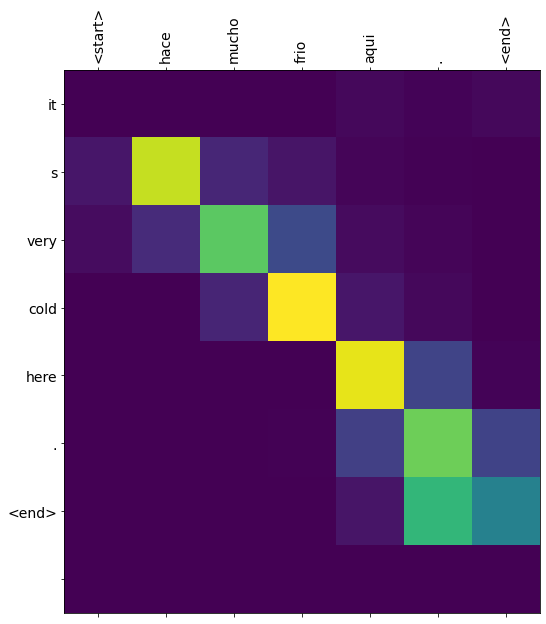

In [26]:
# En : it's really cold here
translate(u'hace mucho frío aquí.')